In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn import tree

from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [6]:
dfT=pd.read_csv(r'/content/drive/My Drive/Highway Traffic/processed_580_TollRates_201702-201907_15_interval.csv')
dfV=pd.read_csv(r'/content/drive/My Drive/Highway Traffic/all_gantries_2016-2019.csv')

In [7]:
#East and West are analyzed separately because the number of plaza and express lanes is different for them.

mask = dfV['Plaza_Id'].str.contains('E')
dfVE=dfV.loc[mask]
dfVW=dfV.loc[~mask]

E=['HACIE','FALLE','AIRWE','LIVEE','NFIRE','VASCE','GREEE']
dfTE=dfT[dfT.From_Zone.isin(E)]
dfTW=dfT[~dfT.From_Zone.isin(E)]

dfV=dfVE
dfT=dfTE
plaza_number=15
del dfVW, dfTW
part='E'

# dfV=dfVW
# dfT=dfTW
# del dfVE, dfTE
# plaza_number=17
# part='W'

In [8]:
#Define DateTime column
def lookup_date(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

dfT['DateTime'] = pd.to_datetime(lookup_date(dfT['DMS_Display_Time_End']).astype(str))

def lookup_date(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

def lookup_time(s):
    times = {time:pd.to_datetime(time).time() for time in s.unique()}
    return s.map(times)

dfV['DateTime'] = pd.to_datetime(lookup_date(dfV['Date']).astype(str) + ' ' + lookup_time(dfV['Time_Ending']).astype(str))


#Define Zone column and to replace the name of Plaza to E1, E2, … to be easier.
dfV['Zone']=dfV['Plaza_Id']
dfV=dfV.replace({'Zone' : { 'E1':'HACIE','E2':'HACIE','E3': 'FALLE','E4': 'FALLE',
                          'E5':'AIRWE','E6':'LIVEE', 'E7':'LIVEE', 'E8':'LIVEE',
                          'E9':'NFIRE','E10':'NFIRE','E11':'VASCE', 'E12':'VASCE',
                          'E13':'GREEE', 'E14':'GREEE', 'E15':'GREEE',
                           'W1': 'GREEW', 'W2': 'GREEW','W3': 'GREEW',
                          'W4':'NFIRW', 'W5':'NFIRW', 'W6':'NFIRW',
                           'W7':'LIVEW', 'W8':'LIVEW', 'W9':'LIVEW','W10':'ISABW',
                          'W11':'AIRWW', 'W12':'AIRWW','W13': 'FALLW', 'W14': 'FALLW',
                          'W15':'SANRW','W16':'HOPYW', 'W17':'HOPYW'}})

#Sort with DateTime
dfT=dfT.sort_values(by='DateTime',ascending=True)
dfV=dfV.sort_values(by='DateTime',ascending=True)

#Define Toll (dropping "Lane closed")
dfT['Toll']=dfT['DMS_Display_Toll_Message']
dfT=dfT.replace({'Toll':{'LANE CLOSED':0}})
dfT['Toll']=dfT['Toll'].astype(float)
#Define Zone_N column and consider the number for plazas based on their order (dfV)
dfT['From_Zone_N']=dfT['From_Zone']
dfT['To_Zone_N']=dfT['To_Zone']
mask={'HACIE':0,'FALLE':1,'AIRWE':2,'LIVEE':3,'NFIRE':4,'VASCE':5,'GREEE':6,'GREEW':0,'NFIRW':1,'LIVEW':2,'ISABW':3,'AIRWW':4,'FALLW':5,'SANRW':6,'HOPYW':7}
dfT=dfT.replace({'From_Zone_N':mask,'To_Zone_N':mask})
dfT['N_Zones']=dfT['To_Zone_N']-dfT['From_Zone_N']
dfT=dfT.drop(['From_Zone_N','To_Zone_N'],axis=1)

In [9]:
#Define Number of Zones for  From_Zone and To_Zone (in dfT) based on their order just like  Zone_N in dfV
mask={'HACIE':0,'FALLE':1,'AIRWE':2,'LIVEE':3,'NFIRE':4,'VASCE':5,'GREEE':6,'GREEW':0,
      'NFIRW':1,'LIVEW':2,'ISABW':3,'AIRWW':4,'FALLW':5,'SANRW':6,'HOPYW':7}
dfT['From_Zone_N']=dfT['From_Zone']
dfT['To_Zone_N']=dfT['To_Zone']
dfT=dfT.replace({'From_Zone_N':mask,'To_Zone_N':mask})
dfV['Zone_N']=dfV['Zone']
dfV=dfV.replace({'Zone_N':mask})

#Define the volume of all lanes ('Vol_all'), express lanes ('Vol_exp'), general lanes ('Vol_normLn'),
#  and the partition them to 6 parts in 3 new columns ('Vol_exp_part', 'Vol_normLn_part', 'Vol_all_part')
dfV['Vol_all']=dfV['Vol_Ln1']+dfV['Vol_Ln2']+dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']
if part=='E':
  dfV['Vol_exp']=dfV['Vol_Ln1']+dfV['Vol_Ln2']
  dfV['Vol_normLn']=dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']
else:
  dfV['Vol_exp']=dfV['Vol_Ln1']
  dfV['Vol_normLn']=+dfV['Vol_Ln2']+dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']

def volume_partition16(df,new_feature,old_feature):
    df[new_feature]=df[old_feature]
    old_min=df[new_feature].min()
    old_max=df[new_feature].max()
    new_min=1
    new_max=6
    df[new_feature]=( (df[new_feature] - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    df[new_feature]=df[new_feature].astype(int)

volume_partition16(dfV,'Vol_exp_part','Vol_exp')
volume_partition16(dfV,'Vol_normLn_part','Vol_normLn')
volume_partition16(dfV,'Vol_all_part','Vol_all')

#different Lane(hue:Rush Hour)
Voll_time_mean=dfV.groupby(by=dfV['DateTime'].dt.time)['Vol_all'].mean()
RHour=np.where(Voll_time_mean.values>1350,'RH','norm')
Voll_time_mean
df=pd.DataFrame({'time':Voll_time_mean.index,'Vol_all':Voll_time_mean.values,'RHour':RHour})
rh=df[df['RHour']=='RH']['time']
dfV['RHour']=np.where(dfV['DateTime'].dt.time.isin(rh),'RH','norm')

In [10]:
def VolSpeed():
  #different palaza_Id for one lane (hue:PMAM)
  if plaza_number>16:
    a=6
    b=3
  else:
    a=4
    b=4

  fig, ax = plt.subplots(a,b,figsize=(22,32),sharex=True,sharey=True)
  ax = ax.ravel()
  plaza=np.sort(dfV['Plaza_Id'].unique())
  for i in range(plaza_number):
    plaz=plaza[i]
    dfV1=dfV[dfV['Plaza_Id']==plaz]
    dfV1['PMAM'] = np.where(dfV1['Hour'] > 12, 'PM', 'AM')
    sns.scatterplot(x = 'Vol_Ln1',y ='Spd_Ln1', hue = 'PMAM', data = dfV1, ax = ax[i], alpha = 0.3)
    ax[i].set_title(plaz)

  #different Lane (no matter which plaza) (hue:PMAM)
  dfV2=dfV.sample(15000)
  dfV2['PMAM'] = np.where(dfV2['Hour'] > 12, 'PM', 'AM')
  fig,ax=plt.subplots(2,4,figsize=(24,8))
  ax = ax.ravel()
  for i in range(7):
    vol='Vol_Ln'+str(i+1)
    sp='Spd_Ln'+str(i+1)
    sns.scatterplot(x = vol,y =sp, hue = 'PMAM', data = dfV2, ax = ax[i], alpha = 0.4)
    ax[i].set_xlim(0,600)
    ax[i].set_ylim(0,100)

  dfV3=dfV.sample(15000)
  fig,ax=plt.subplots(2,4,figsize=(24,8))
  ax = ax.ravel()
  for i in range(7):
    vol='Vol_Ln'+str(i+1)
    sp='Spd_Ln'+str(i+1)
    sns.scatterplot(x = vol,y =sp, hue = 'RHour', data = dfV3, ax = ax[i], alpha = 0.4)
    ax[i].set_xlim(0,600)
    ax[i].set_ylim(0,100)

  #distribution of volume of different lanes & dist for voll_al>1350
def distvolume():
  fig, ax=plt.subplots()
  sns.distplot(dfV['Vol_all'],ax=ax)
  ax.set_title('distribution the some of all lanes volumes')
  dfV3=dfV
  dfV3['PMAM']=np.where(dfV3['Hour']>12,'PM','AM')
  dfV3A=dfV3[dfV3['PMAM']=='AM']
  dfV3P=dfV3[dfV3['PMAM']=='PM']
  fig, ax=plt.subplots(2,4,figsize=(22,15))
  ax=ax.ravel()
  sns.distplot(dfV3A['Vol_Ln1'],ax=ax[0])
  ax[0].set_title('Vol1 in AM')
  sns.distplot(dfV3P['Vol_Ln1'],ax=ax[1])
  ax[1].set_title('Vol1 in PM')
  sns.distplot(dfV3A['Vol_Ln2'],ax=ax[2])
  ax[2].set_title('Vol2 in AM')
  sns.distplot(dfV3P['Vol_Ln2'],ax=ax[3])
  ax[3].set_title('Vol2 in PM')
  sns.distplot(dfV3A['Vol_Ln3'],ax=ax[4])
  ax[4].set_title('Vol3 in AM')
  sns.distplot(dfV3P['Vol_Ln3'],ax=ax[5])
  ax[5].set_title('Vol3 in PM')
  sns.distplot(dfV3A['Vol_Ln4'],ax=ax[6])
  ax[6].set_title('Vol4 in AM')
  sns.distplot(dfV3P['Vol_Ln4'],ax=ax[7])
  ax[7].set_title('Vol4 in PM')

  dfV3=dfV[dfV['Vol_all']>1500]
  dfV3['PMAM']=np.where(dfV3['Hour']>12,'PM','AM')
  dfV3A=dfV3[dfV3['PMAM']=='AM']
  dfV3P=dfV3[dfV3['PMAM']=='PM']
  fig, ax=plt.subplots(2,4,figsize=(22,15))
  ax=ax.ravel()
  sns.distplot(dfV3A['Vol_Ln1'],ax=ax[0])
  ax[0].set_title('Vol1 in AM_rush hour')
  sns.distplot(dfV3P['Vol_Ln1'],ax=ax[1])
  ax[1].set_title('Vol1 in PM_rush hour')
  sns.distplot(dfV3A['Vol_Ln2'],ax=ax[2])
  ax[2].set_title('Vol2 in AM_rush hour')
  sns.distplot(dfV3P['Vol_Ln2'],ax=ax[3])
  ax[3].set_title('Vol2 in PM_rush hour')
  sns.distplot(dfV3A['Vol_Ln3'],ax=ax[4])
  ax[4].set_title('Vol3 in AM_rush hour')
  sns.distplot(dfV3P['Vol_Ln3'],ax=ax[5])
  ax[5].set_title('Vol3 in PM_rush hour')
  sns.distplot(dfV3A['Vol_Ln4'],ax=ax[6])
  ax[6].set_title('Vol4 in AM_rush hour')
  sns.distplot(dfV3P['Vol_Ln4'],ax=ax[7])
  ax[7].set_title('Vol4 in PM_rush hour')

# mean+-std volume and speed based on time
def average_all_times(df, lane_num):
    variable_vol = 'Vol_Ln' + str(lane_num)
    variable_spd = 'Spd_Ln' + str(lane_num)
    plaza=np.sort(dfV['Plaza_Id'].unique())
    fig, ax1 = plt.subplots(4,2,figsize=(12,8))
    for i,ax_1 in enumerate(ax1.flatten()):
        Plaza_ID=plaza[i]
        daily_vol_avg = df.loc[(df['Plaza_Id'] == Plaza_ID)].groupby(by = df['DateTime'].dt.time)[variable_vol].mean()
        daily_vol_std = df.loc[(df['Plaza_Id'] == Plaza_ID)].groupby(by = df['DateTime'].dt.time)[variable_vol].std()
        daily_spd_avg = df.loc[(df['Plaza_Id'] == Plaza_ID)].groupby(by = df['DateTime'].dt.time)[variable_spd].mean()
        daily_spd_std = df.loc[(df['Plaza_Id'] == Plaza_ID)].groupby(by = df['DateTime'].dt.time)[variable_spd].std()
        ax_2 = ax_1.twinx()
        color = 'tab:red'
        ax_1.set_xlabel('time')
        ax_1.set_ylabel('Volume', color=color)
        ax_1.set_title(Plaza_ID)
        daily_vol_avg.plot(ax=ax_1, color=color)
        ax_1.tick_params(axis='y', labelcolor=color)
        ax_1.fill_between(daily_vol_avg.index , daily_vol_avg - daily_vol_std, daily_vol_avg + daily_vol_std,alpha=0.2,color=color)
        color = 'tab:blue'
        ax_2.set_ylabel('Speed', color=color)
        daily_spd_avg.plot(ax=ax_2, color=color)
        ax_2.tick_params(axis='y', labelcolor=color)
        ax_2.fill_between(daily_spd_avg.index , daily_spd_avg - daily_spd_std, daily_spd_avg + daily_spd_std,alpha=0.2,color=color)
        fig.tight_layout()

#mean+_std voolume based on time (hue:Plza_Id)
def mean_vol_time(lane_num):
  variable_vol = 'Vol_Ln' + str(lane_num)
  plaza=np.sort(dfV['Plaza_Id'].unique())
  fig,ax=plt.subplots()
  for i in range(plaza.shape[0]):
    Plaza_ID=plaza[i]
    m=dfV.loc[(dfV['Plaza_Id'] == Plaza_ID)].groupby(by = dfV['DateTime'].dt.time)[variable_vol].mean()
    s=dfV.loc[(dfV['Plaza_Id'] == Plaza_ID)].groupby(by = dfV['DateTime'].dt.time)[variable_vol].std()
    m.plot(ax=ax)
    ax.fill_between(m.index , m - s, m + s,alpha=0.2)

mean+-std volume (blue lines) for different plazza and mean+-std speed (red lines) based on time

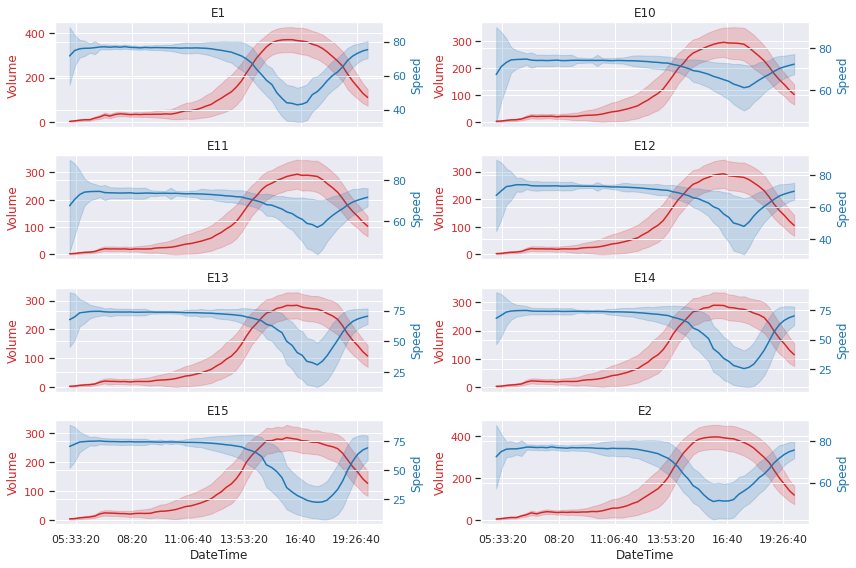

In [11]:
average_all_times(dfV,lane_num=1)

mean+_std voolume of a lane based on time (hue:Plza_Id)

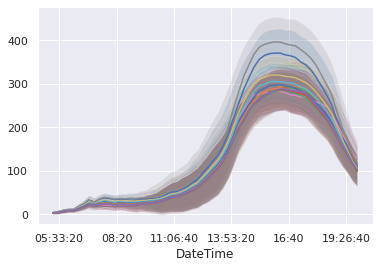

In [12]:
mean_vol_time(1)

In [13]:
# Define 3 columns: mean of speed for all lanes(spead_mean_all) express lanes(spead_mean12), general lanes(spead_mean37)
dfV['spead_mean12']=0.5*(dfV['Spd_Ln1']+dfV['Spd_Ln2'])
dfV['spead_mean37']=(dfV['Spd_Ln3']+dfV['Spd_Ln4']+dfV['Spd_Ln5']+dfV['Spd_Ln6']+dfV['Spd_Ln7'])/5
dfV['spead_mean_all']=(dfV['Spd_Ln1']+dfV['Spd_Ln2']+dfV['Spd_Ln3']+dfV['Spd_Ln4']+dfV['Spd_Ln5']+dfV['Spd_Ln6']+dfV['Spd_Ln7'])/7
V=dfV[['DateTime','spead_mean12','spead_mean37','spead_mean_all','Hour']]

In [14]:
def Toll_NZones():
  #Plot Toll vs N_Zones
  fig, ax=plt.subplots(3,1,figsize=(12,15))
  dfT.groupby(by=['N_Zones'])['Toll'].mean().plot(kind='bar',ax=ax[0])
  sns.violinplot('N_Zones','Toll',data=dfT,ax=ax[1])
  sns.pointplot('N_Zones','Toll','From_Zone',data=dfT,palette='deep',ax=ax[2])
  #dfVT=dfT[['Toll','N_Zones','DateTime']].merge(dfV[['DateTime','RHour','Vol_all','Vol_all_part']],how='inner',on='DateTime')
  #sns.pointplot('N_Zones','Toll','RHour',data=dfVT)

def Toll_simple_plot():
  #distplot of Toll
  fig, ax=plt.subplots(2,1,figsize=(18,8))
  sns.distplot((dfT[dfT['Toll']>0]['Toll']),ax=ax[0])
  sns.distplot(dfT['Toll'],ax=ax[1])

  #plot mean+-std Toll vs Hour & N_Zones
  fig, ax=plt.subplots(1,3,figsize=(25,3))
  mean_T=dfT.groupby(by=['Hour'])['Toll'].mean()
  std_T=dfT.groupby(by=['Hour'])['Toll'].std()
  # ax[0].plot(mean_T.index,mean_T)
  mean_T.plot(ax=ax[0])
  ax[0].fill_between(mean_T.index,mean_T-std_T,mean_T+std_T,alpha=0.2)
  ax[0].set_xlabel('Hour')
  ax[0].set_title('mean toll+-standard deviation')

  mean_T=dfT.groupby(by=['N_Zones'])['Toll'].mean()
  std_T=dfT.groupby(by=['N_Zones'])['Toll'].std()
  # ax[1].plot(mean_T.index,mean_T)
  mean_T.plot(ax=ax[1])
  ax[1].fill_between(mean_T.index,mean_T-std_T,mean_T+std_T,alpha=0.2)
  ax[1].set_xlabel('Number of zones')
  ax[1].set_title('mean toll+-standard deviation')

  dfT1=dfT[dfT['N_Zones']==1]
  mean_T=dfT1.groupby(by=['Hour'])['Toll'].mean()
  std_T=dfT1.groupby(by=['Hour'])['Toll'].std()
  # ax[2].plot(mean_T.index,mean_T)
  mean_T.plot(ax= ax[2])
  ax[2].fill_between(mean_T.index,mean_T-std_T,mean_T+std_T,alpha=0.2)
  ax[2].set_xlabel('Hour')
  ax[2].set_title('N-Zone=1')

  #plots: Toll-Hour & Toll-Month
  #print(dfT.groupby(by=['Year'])['Year'].value_counts())
  fig, ax=plt.subplots(1,2,figsize=(18,6))
  sns.pointplot('Hour','Toll','Year',data=dfT,ax=ax[0])
  sns.pointplot('Month','Toll','Year',data=dfT,ax=ax[1])

#pointplot toll based on volume_all, Vol_exp & Vol_normLn partition(condition: zone=from_zone)
def plot_VolToll(year):
    dfT18=dfT[dfT['Year']==year]
    dfV18=dfV[dfV['Year']==year]
    df18=dfT18.merge(dfV18,on=['DateTime','Hour','Month'], how = 'inner')
    
    df18=df18[['DateTime','From_Zone','To_Zone','N_Zones','DOW','Plaza_Id','Zone','Vol_all','Vol_exp','Vol_normLn','Vol_all_part','Vol_exp_part','Vol_normLn_part','Toll','Month','Hour']]
    df18_fzon=df18[df18['From_Zone']==df18['Zone']]
    df_vt=df18_fzon
    print("Volume are calculated in the zone=*frome zone* in Toll-Table")
    fig,ax=plt.subplots(1,3,figsize=(18,4),sharey=True)
    sns.pointplot('Vol_all_part','Toll','N_Zones',data=df_vt,ax=ax[0])
    sns.pointplot('Vol_exp_part','Toll','N_Zones',data=df_vt,ax=ax[1])
    sns.pointplot('Vol_normLn_part','Toll','N_Zones',data=df_vt,ax=ax[2])

    fig, ax=plt.subplots(1,2,figsize=(16,5))
    sns.pointplot('Hour','Toll','N_Zones',data=df_vt,ax=ax[0])
    sns.pointplot('Month','Toll','N_Zones',data=df_vt,ax=ax[1])


#pointplot toll based on volume_all, Vol_exp & Vol_normLn  partition (zone=1 zone before from_zone)
def VolToll_1bzone(year):
  dfT18=dfT[dfT['Year']==year]
  dfV18=dfV[dfV['Year']==year]
  df18=dfT18.merge(dfV18,on=['DateTime','Hour','Month'], how = 'inner')
  df18=df18[['DateTime','From_Zone','To_Zone','N_Zones','DOW','Plaza_Id','Zone','Vol_all','Vol_exp','Vol_normLn','Vol_all_part','Vol_exp_part','Vol_normLn_part','Toll','Month','Hour','Zone_N','From_Zone_N']]
  #condition1
  df1_1b=df18[df18['From_Zone_N']-df18['Zone_N']==1]
  print("Condition: Volumes are calculated in one zone before *frome zone* in Toll-Table")

  fig,ax=plt.subplots(1,3,figsize=(18,4),sharey=True)
  sns.pointplot('Vol_all_part','Toll','N_Zones',data=df1_1b,ax=ax[0])
  sns.pointplot('Vol_exp_part','Toll','N_Zones',data=df1_1b,ax=ax[1])
  sns.pointplot('Vol_normLn_part','Toll','N_Zones',data=df1_1b,ax=ax[2])
  ax[0].set_title('Toll vs all Volume')
  ax[1].set_title('Toll vs Volume express Lanes')
  ax[2].set_title('Toll vs General Lanes')

  fig, ax=plt.subplots(1,2,figsize=(16,5))
  sns.pointplot('Hour','Toll','N_Zones',data=df1_1b,ax=ax[0])
  sns.pointplot('Month','Toll','N_Zones',data=df1_1b,ax=ax[1])


#pointplot toll based on vvolume_all, Vol_exp & Vol_normLn partition (volumes of 15 min before)
def VolTol_l_1btime(year):
  dfT1=dfT[dfT['Year']==year]
  dfV_s=dfV[dfV['Year']==year]
  plaza=dfV_s['Plaza_Id'].unique()
  df_all=[]
  for i in range(plaza.shape[0]):
    df=dfV_s[dfV_s['Plaza_Id']==plaza[i]]
    df['diff_time']=pd.to_datetime(df['DateTime'])-pd.to_datetime(df['DateTime'].shift(1))
    df['Vol_all_1b']=df['Vol_all'].shift(1)
    df['Vol_exp_1b']=df['Vol_exp'].shift(1)
    df['Vol_normLn_1b']=df['Vol_normLn'].shift(1)
    dt=['0 days 00:14:00','0 days 00:15:00','0 days 00:16:00']
    df=df[df.diff_time.isin(dt)]
    df_all.append(df)
  all_df=pd.concat(df_all)
  dfV_=all_df.sort_values(by='DateTime',ascending=True)
  dfVT=dfT1.merge(dfV_[['DateTime','Zone','Zone_N','Vol_all','Vol_exp','Vol_normLn','DOW','Month','Hour','Vol_all_1b','Vol_exp_1b','Vol_normLn_1b']],on=['DateTime','Hour','Month'], how = 'inner')
  dfVT=dfVT[['DateTime','From_Zone','To_Zone','N_Zones','Zone','From_Zone_N','To_Zone_N','Zone_N','Vol_all','Vol_exp','Vol_normLn','Toll','DOW','Month','Hour','Vol_all_1b','Vol_exp_1b','Vol_normLn_1b']]
  volume_partition16(dfVT,'Vol_exp_1b_part','Vol_exp_1b')
  volume_partition16(dfVT,'Vol_normLn_1b_part','Vol_normLn_1b')
  volume_partition16(dfVT,'Vol_all_1b_part','Vol_all_1b')
  dfVT=dfVT[dfVT['From_Zone']==dfVT['Zone']]
  fig, ax=plt.subplots(1,3,figsize=(18,5))
  sns.pointplot('Vol_all_1b_part','Toll','N_Zones',data=dfVT,ax=ax[0])
  sns.pointplot('Vol_exp_1b_part','Toll','N_Zones',data=dfVT,ax=ax[1])
  sns.pointplot('Vol_normLn_1b_part','Toll','N_Zones',data=dfVT,ax=ax[2])
  ax[0].set_title('Toll vs Volume of 15min befor for a part of data')
  dfVT=dfT1.merge(dfV_[['DateTime','Zone','Zone_N','Vol_all','Vol_exp','Vol_normLn','DOW','Month','Hour','Vol_all_part','Vol_exp_part','Vol_normLn_part']],on=['DateTime','Hour','Month'], how = 'inner')
  dfVT=dfVT[['DateTime','From_Zone','To_Zone','N_Zones','Zone','From_Zone_N','To_Zone_N','Zone_N','Vol_all','Vol_exp','Vol_normLn','Toll','DOW','Month','Hour','Vol_all_part','Vol_exp_part','Vol_normLn_part']]
  dfVT=dfVT[dfVT['From_Zone']==dfVT['Zone']]
  fig, ax=plt.subplots(1,3,figsize=(18,5))
  sns.pointplot('Vol_all_part','Toll','N_Zones',data=dfVT,ax=ax[0])
  sns.pointplot('Vol_exp_part','Toll','N_Zones',data=dfVT,ax=ax[1])
  sns.pointplot('Vol_normLn_part','Toll','N_Zones',data=dfVT,ax=ax[2])
  ax[0].set_title('Toll vs Volume for a part of data')


#some 3d plot of Toll and some features
def Toll3plot(sample):
  dfVT=dfT[['Toll','N_Zones','From_Zone','DateTime']].merge(dfV[['DateTime','RHour','Hour','Vol_all','Vol_all_part','Zone']],how='inner',on='DateTime')
  dfVT=dfVT[dfVT['From_Zone']==dfVT['Zone']]
  mask={'norm':1,'RH':2}
  dfVT=dfVT.replace({'RHour':mask})
  dfVT=dfVT.sample(sample)
  fig = plt.figure(figsize=(25,25))
  ax = fig.add_subplot(221, projection='3d')
  ax.plot_trisurf(dfVT.N_Zones, dfVT.Hour, dfVT.Toll,cmap=cm.jet, linewidth=0.2)
  ax.set_xlabel('Nomber of Zones')
  ax.set_ylabel('Hour')
  ax.set_zlabel('Toll')
  ax.set_title('Toll-NZones&Hour for 50000 samples of data')
  ax2 =fig.add_subplot(222, projection='3d')
  ax2.plot_trisurf(dfVT.N_Zones, dfVT.Vol_all_part, dfVT.Toll,cmap=cm.jet, linewidth=0.2)
  ax2.set_xlabel('Nomber of Zones')
  ax2.set_ylabel('Vol_all_part')
  ax2.set_zlabel('Toll')
  ax2.set_title('Toll-NZones&Vollume for 50000 samples of data')
  #plt.show()

  dfVT=dfT[['Toll','N_Zones','DateTime','From_Zone']].merge(dfV[['DateTime','RHour','Hour','Vol_all','Vol_all_part','Zone']],how='inner',on='DateTime')
  dfVT=dfVT[dfVT['From_Zone']==dfVT['Zone']]
  dfVT=dfVT.sample(sample)
  mask={'norm':1,'RH':0}
  dfVT=dfVT.replace({'RHour':mask})
  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)
  ax.scatter(dfVT['N_Zones'], dfVT['Vol_all_part'],dfVT['Toll'], zdir='z', s=20, c=dfVT['RHour'],cmap=cm.jet, depthshade=True)
  ax.set_xlabel('N_Zones')
  ax.set_ylabel('Vollum_all_part')
  ax.set_zlabel('Toll')
  ax.set_title('Toll-N_Zones&Voll_all_part (1000 samples)')
  plt.legend()
  #plt.show()


Scatter plot, x axis is volume and y axis is speed and each plot is for a plaza

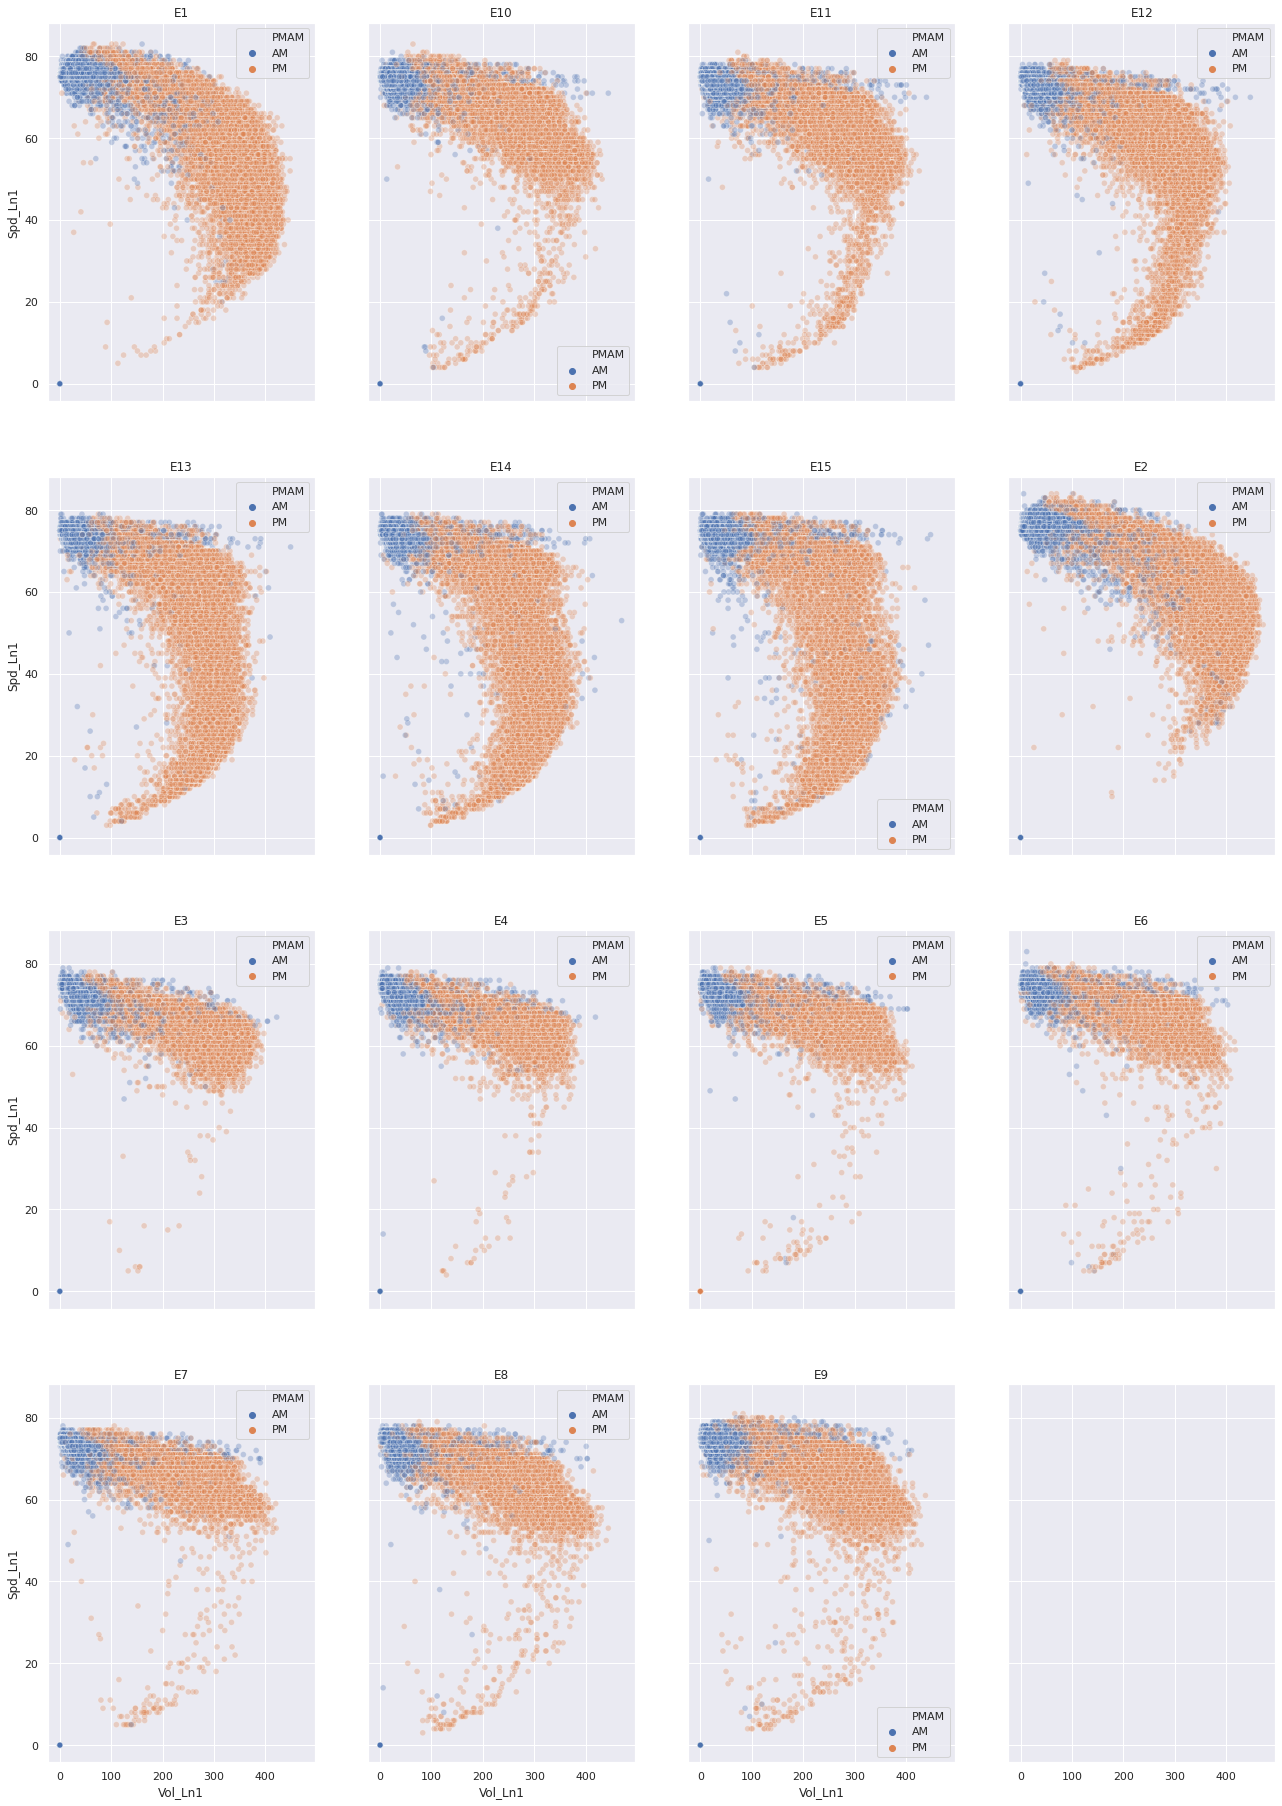

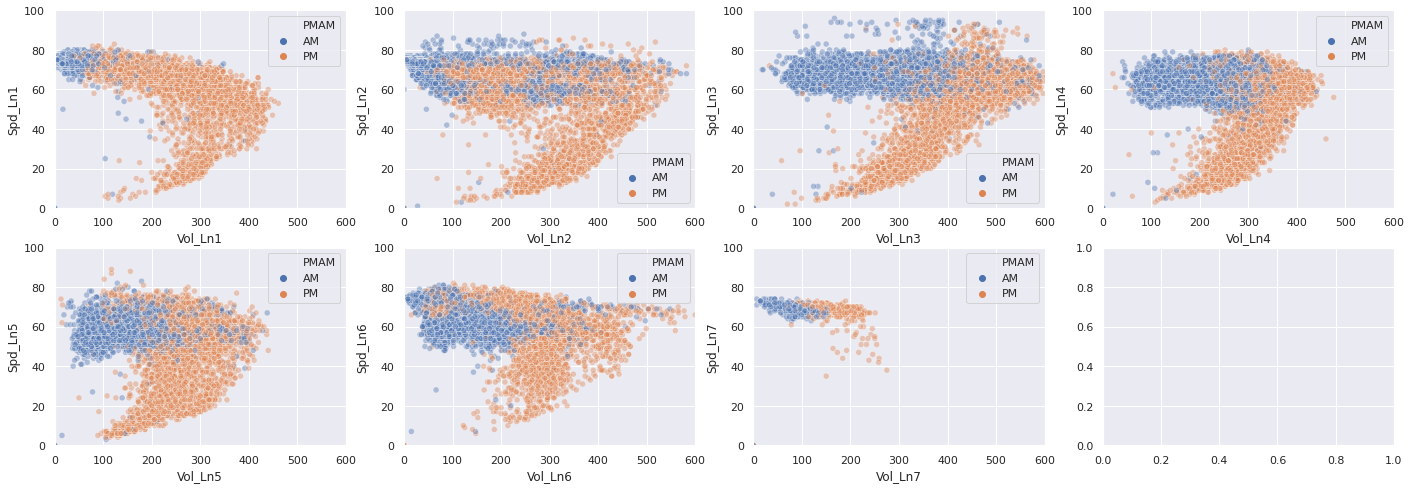

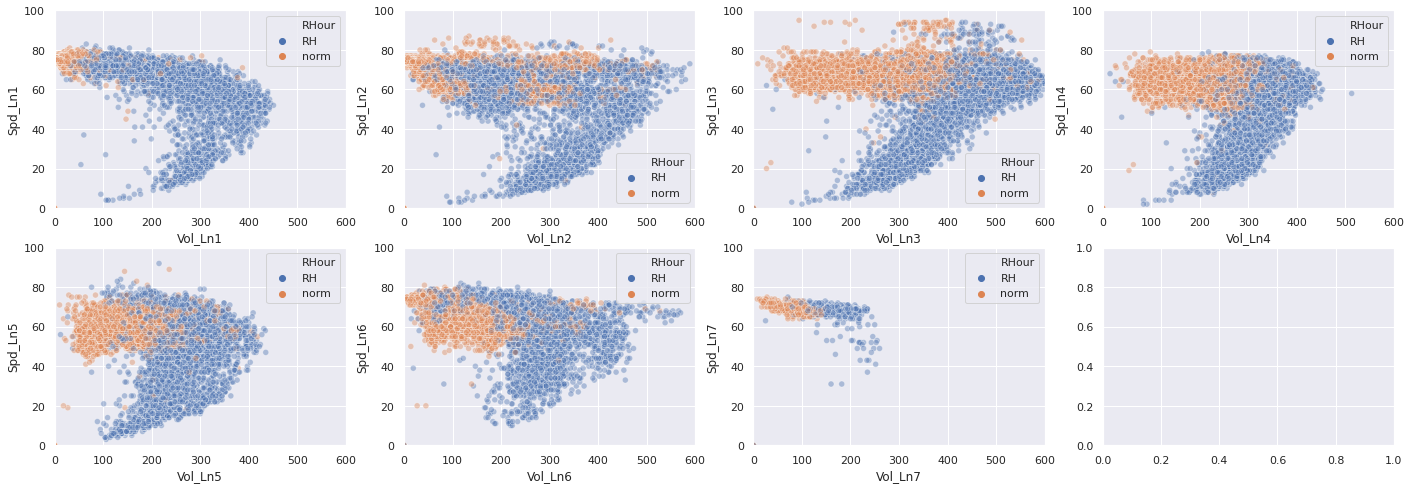

In [15]:
VolSpeed()

point plot that shows mean of Toll for volume of all lanes, volume of express lanes, and volume of general lanes(volumes are partitioned), hour and month. color shows the number of zones between from_zone to to_zone and all plots show data of a year defined as input of function(like 2018)

Volume are calculated in the zone=*frome zone* in Toll-Table


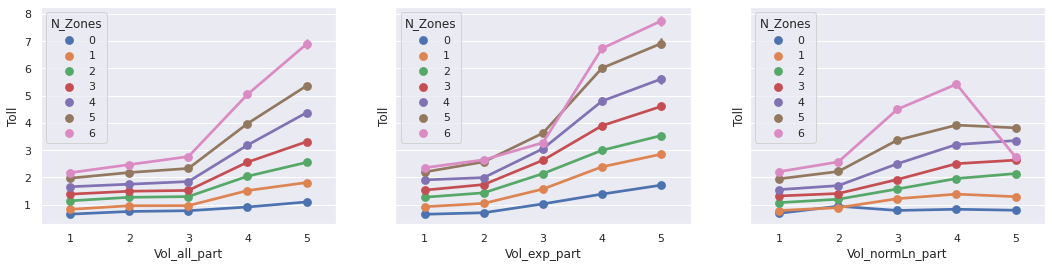

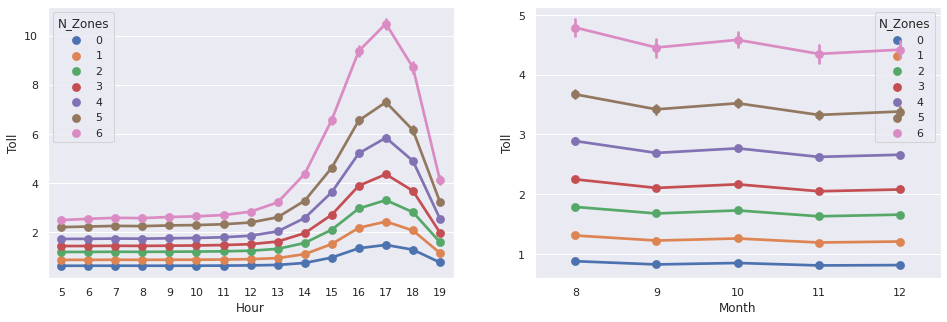

In [16]:
plot_VolToll(2018)

VolToll_1bzone is like plot_VolToll with a difference:in plot_VolToll all volumes are volumes of the from_zone but in VolToll_1bzone volumes are volumes of one zone before from_zone

Condition: Volumes are calculated in one zone before *frome zone* in Toll-Table


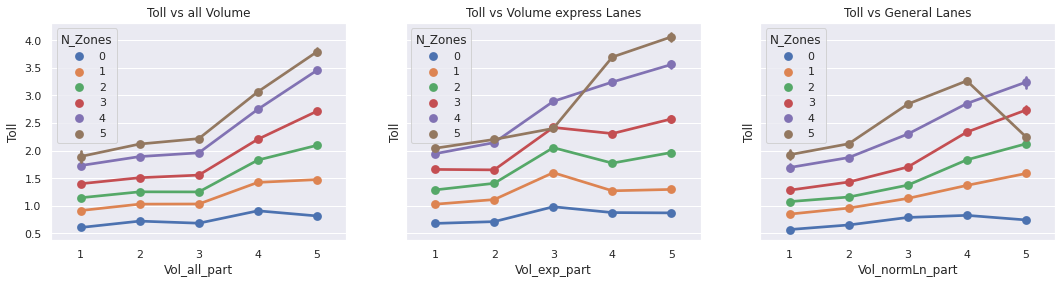

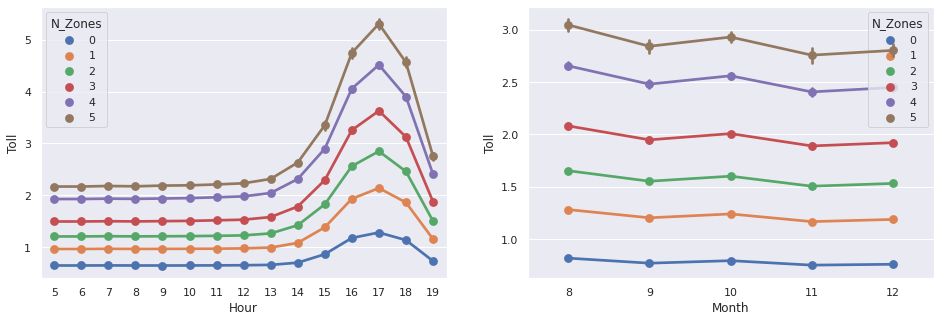

In [17]:
#condition: one zone before from_zone
VolToll_1bzone(year=2018)

3d plots that show dependency of Toll to the number of zones and hour or volume of express lanes

No handles with labels found to put in legend.


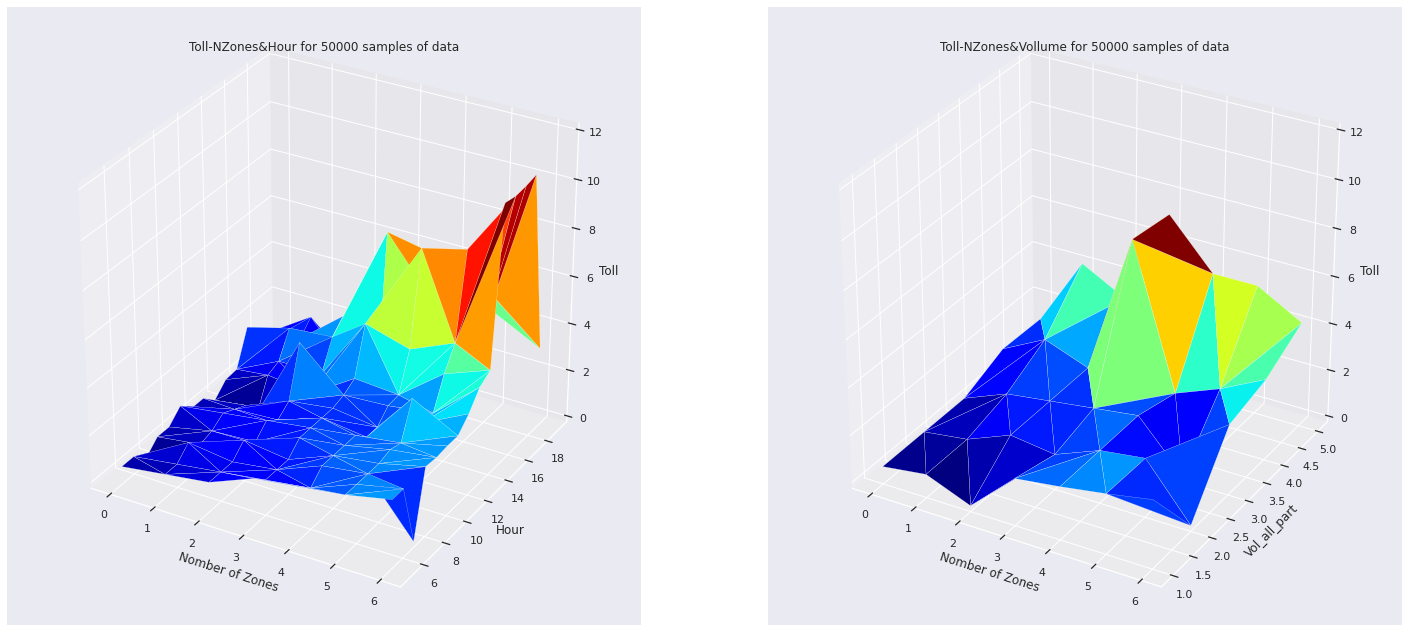

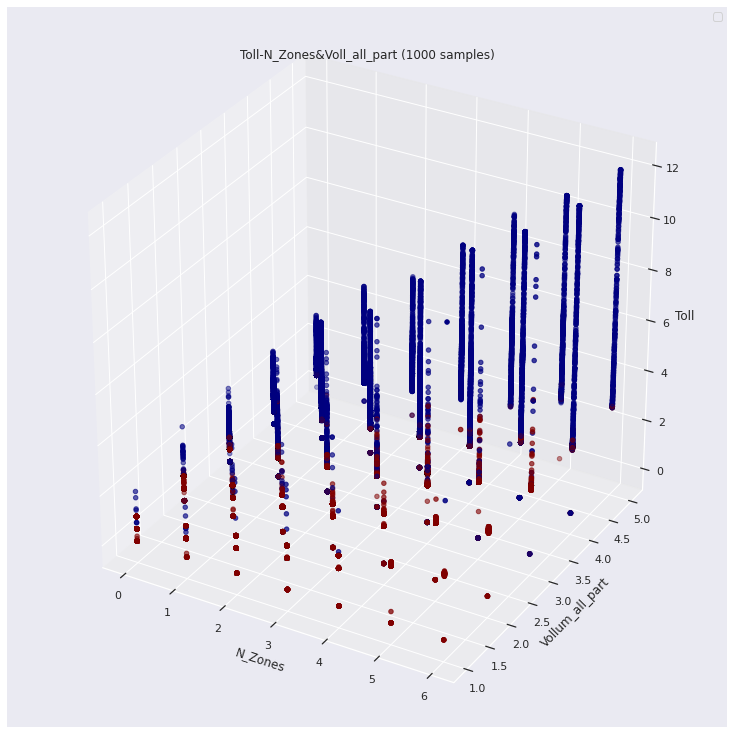

In [18]:
Toll3plot(50000)

Some simple plots to analyze Toll distribution

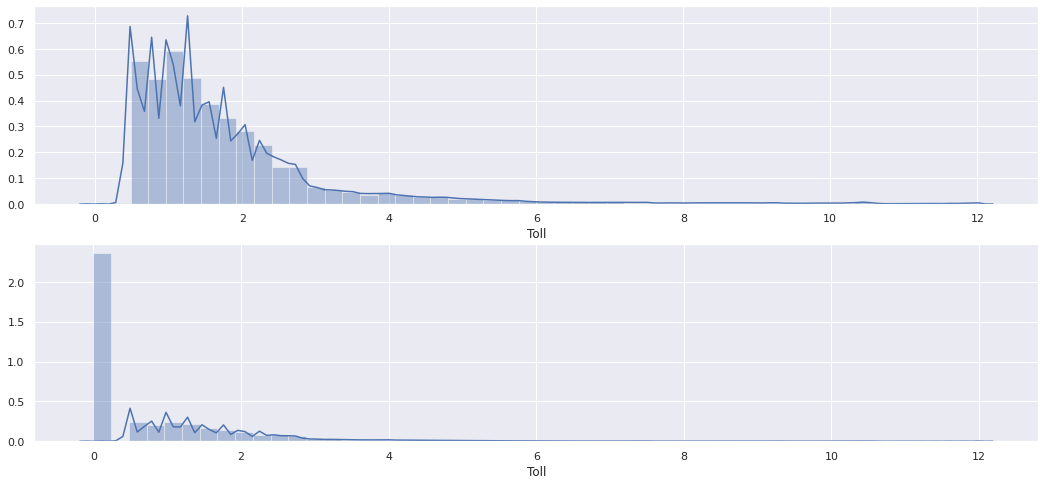

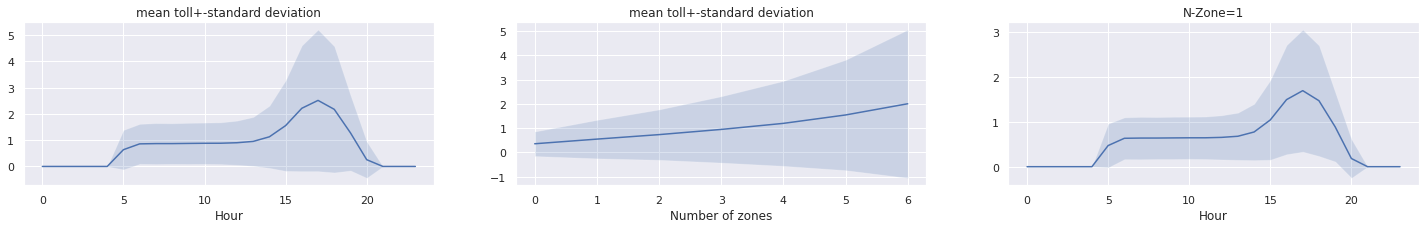

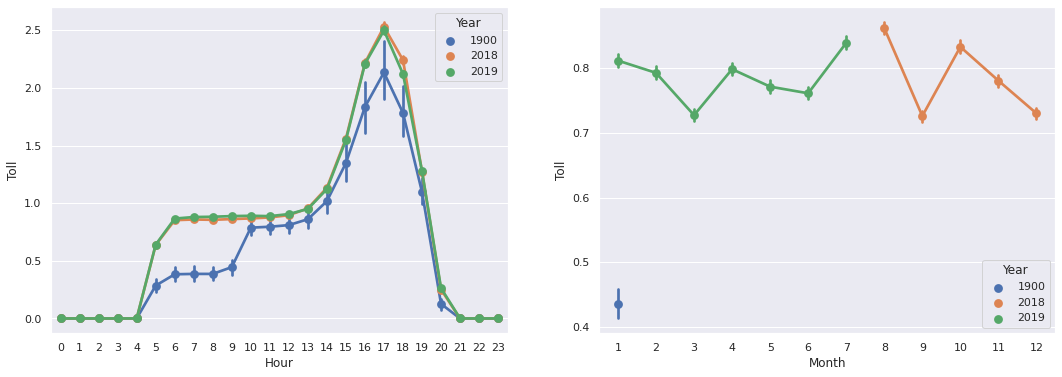

In [19]:
Toll_simple_plot()

In [20]:
#volume of express lanes vs mean toll of one zone; it can show driveres' decision
  dfVT=dfT.merge(dfV[['DateTime','Plaza_Id','Zone','Zone_N','Vol_all','Vol_exp','Vol_normLn','DOW','Year','Month','Hour','Vol_all_part','Vol_exp_part','Vol_normLn_part']],on=['DateTime','Year','Hour','Month'], how = 'inner')
  dfVT=dfVT[['DateTime','Plaza_Id','From_Zone','To_Zone','N_Zones','Zone','From_Zone_N','To_Zone_N','Zone_N','Vol_all','Vol_exp','Vol_normLn','Toll','DOW','Year','Month','Hour','Vol_all_part','Vol_exp_part','Vol_normLn_part']]
  dfVT=dfVT[dfVT['From_Zone']==dfVT['Zone']]
  dfVT=dfVT[['DateTime','Plaza_Id','N_Zones','Year','Month','DOW','Hour','Vol_all_part','Vol_exp_part','Vol_normLn_part','Vol_all','Vol_exp','Vol_normLn','Toll']]
  dfVT['Toll/N']=dfVT['Toll']/(1+dfVT['N_Zones'])
  dfVT= dfVT.sort_values(by='DateTime',ascending=True)
fig, ax=plt.subplots(figsize=(12,8))
dfVT.groupby(by=['Toll/N'])['Vol_exp'].mean().plot(ax=ax)
ax.set_ylabel("Volume of express lanes")

IndentationError: ignored

define residual volume of all lanes, express lanes, and general lanes= volumes  - mean of volumes in that specific time
and then plot of mean volumes and residual volumes

In [ ]:
dfV['Vol_all_mean']=dfV['Hour']
dfV['Vol_exp_mean']=dfV['Hour']
dfV['Vol_normLn_mean']=dfV['Hour']
dfV['Vol_normLn_mean']=dfV['Vol_normLn_mean'].map({5:1354.025021,6:1407.827911,7:1423.866543,8:1377.301227,9:1331.539027,10:1270.718096,
                                                     11:1222.845681,12:1202.307736,13:1189.935645,14:1153.057906,15:1149.149928,16:1203.923067,17:1174.978251,18:973.203764,19:771.938747,20:641.802852})
dfV['Vol_exp_mean']=dfV['Vol_exp_mean'].map({5:255.150393,6:254.634589,7:265.751720,8:237.145888,9:187.529952,10:120.088891	,
                                               11:86.475232,12:76.570744,13:72.556690,14:67.064527,15:68.112171	,16:81.320462,17:79.920019,18:50.607350,19:30.860370,20:63.348663})
dfV['Vol_all_mean']=dfV['Vol_all_mean'].map({5:1609.175414,6:1662.462500,7:1689.618263,8:1614.447115,9:1519.068980	,10:1390.806987,
                          11:1309.320912,12:1278.878481,13:1262.492335,14:1220.122433	,15:1217.262099,16:1285.243529,17:1254.898270,18:1023.811114,19:802.799117,20:705.151515})
dfV['vol_all_res']=dfV['Vol_all']-dfV['Vol_all_mean']
dfV['vol_exp_res']=dfV['Vol_exp']-dfV['Vol_exp_mean']
dfV['vol_nor_res']=dfV['Vol_normLn']-dfV['Vol_normLn_mean']

fig, ax = plt.subplots(3,1,figsize=(12,14))
ax=ax.ravel()

ax[0].scatter(dfV['Hour'], dfV['vol_exp_res'],label='vol_exp_res',color=next(color_cycle))
dfV.groupby(by=['Hour'])['Vol_exp_mean'].mean().plot(ax=ax[0],label='mean volume of express',color=next(color_cycle))
ax[0].legend()
ax[0].set_title('Express Lanes Volume')

ax[1].scatter(dfV['Hour'], dfV['vol_all_res'],label='vol_all_residual',color=next(color_cycle))
dfV.groupby(by=['Hour'])['Vol_all_mean'].mean().plot(ax=ax[1],label='mean volume of all',color=next(color_cycle))
ax[1].legend()
ax[1].set_title('All Lanes Volume')

ax[2].scatter(dfV['Hour'], dfV['vol_nor_res'],label='vol_nor_residual',color=next(color_cycle))
dfV.groupby(by=['Hour'])['Vol_normLn_mean'].mean().plot(ax=ax[2],label='mean volume of normal',color=next(color_cycle))
ax[2].legend()
ax[2].set_title('General Lanes Volume')

Define volume for one step, 2 step and 3 step times before

In [ ]:
dfV['Vol_all']=dfV['Vol_Ln1']+dfV['Vol_Ln2']+dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']
if part=='E':
  dfV['Vol_exp']=dfV['Vol_Ln1']+dfV['Vol_Ln2']
  dfV['Vol_normLn']=dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']
  dfV['spead_mean_exp']=0.5*(dfV['Spd_Ln1']+dfV['Spd_Ln2'])
  dfV['spead_mean_norm']=(dfV['Spd_Ln3']+dfV['Spd_Ln4']+dfV['Spd_Ln5']+dfV['Spd_Ln6']+dfV['Spd_Ln7'])/5
else:
  dfV['Vol_exp']=dfV['Vol_Ln1']
  dfV['Vol_normLn']=+dfV['Vol_Ln2']+dfV['Vol_Ln3']+dfV['Vol_Ln4']+dfV['Vol_Ln5']+dfV['Vol_Ln6']+dfV['Vol_Ln7']
  dfV['spead_mean_exp']=dfV['Spd_Ln1']
  dfV['spead_mean_norm']=(dfV['Spd_Ln2']+dfV['Spd_Ln3']+dfV['Spd_Ln4']+dfV['Spd_Ln5']+dfV['Spd_Ln6']+dfV['Spd_Ln7'])/6

plaza=dfV['Plaza_Id'].unique()
df_all=[]
for i in range(plaza.shape[0]):
  df=dfV[dfV['Plaza_Id']==plaza[i]]
  df['diff_time']=pd.to_datetime(df['DateTime'])-pd.to_datetime(df['DateTime'].shift(1))
  df['Vol_all_1b']=df['Vol_all'].shift(1)
  df['Vol_exp_1b']=df['Vol_exp'].shift(1)
  df['Vol_normLn_1b']=df['Vol_normLn'].shift(1)
  df['diff_time2']=pd.to_datetime(df['DateTime'])-pd.to_datetime(df['DateTime'].shift(2))
  df['Vol_all_2b']=df['Vol_all'].shift(2)
  df['Vol_exp_2b']=df['Vol_exp'].shift(2)
  df['Vol_normLn_2b']=df['Vol_normLn'].shift(2)
  df['diff_time3']=pd.to_datetime(df['DateTime'])-pd.to_datetime(df['DateTime'].shift(3))
  df['Vol_all_3b']=df['Vol_all'].shift(3)
  df['Vol_exp_3b']=df['Vol_exp'].shift(3)
  df['Vol_normLn_3b']=df['Vol_normLn'].shift(3)
  df=df[df.diff_time.isin(['0 days 00:14:00','0 days 00:15:00','0 days 00:16:00'])]
  df_all.append(df)
all_df=pd.concat(df_all)
dfV_=all_df.sort_values(by='DateTime',ascending=True)
dfV_=dfV_[dfV_.diff_time2.isin(['0 days 00:29:00','0 days 00:30:00','0 days 00:31:00']) & dfV_.diff_time3.isin([' 0 days 00:44:00','0 days 00:45:00','0 days 00:46:00'])]

dfT=dfT.drop(dfT[dfT.Toll==0].index)

df_final=dfV_[['DateTime','Vol_exp','Vol_normLn','Vol_all','vol_all_res','vol_exp_res','vol_nor_res','Vol_all_1b', 'Vol_exp_1b', 'Vol_normLn_1b','Vol_all_2b','Vol_exp_2b','Vol_normLn_2b','Vol_all_3b',
               'Vol_exp_3b','Vol_normLn_3b','spead_mean_exp','spead_mean_norm','Year', 'Month','DOW_Num','Hour','Zone']].merge(dfT,on=['DateTime','Year','Hour','Month'])
df_final=df_final[df_final['Zone']==df_final['From_Zone']]
df_final['Toll/NZ']=df_final['Toll']/(1+df_final['N_Zones'])
df_final['Zone_N']=df_final['Zone']
mask={'HACIE':0,'FALLE':1,'AIRWE':2,'LIVEE':3,'NFIRE':4,'VASCE':5,'GREEE':6,'GREEW':0,'NFIRW':1,'LIVEW':2,'ISABW':3,'AIRWW':4,'FALLW':5,'SANRW':6,'HOPYW':7}
df_final=df_final.replace({'Zone_N':mask})

Feature seceltion to set as input of machine learning model that is random forest regressor; training the model and predicting for test dataset.

In [ ]:
# features=['Toll/NZ','Hour','Year','Month','vol_all_res','vol_exp_res','vol_nor_res']
# features=['Zone_N','Toll', 'Vol_all_1b','Vol_exp_1b', 'Vol_normLn_1b', 'Year', 'Month','Hour']
# features=['Zone_N','Toll','Hour','Year','Month','DOW_Num']
# features=['Toll/NZ','Hour','Year','Month']
# features=['Vol_all_3b','Vol_exp_3b','Vol_normLn_3b','Toll/NZ','Hour','Year','Month']
# features=[ 'Vol_all_1b','Vol_exp_1b', 'Vol_normLn_1b', 'Year', 'Month','Hour']
# features=['Vol_all_1b','Vol_all_2b','Toll/NZ','Hour','Year','Month']
features=['Vol_all_1b','Vol_all_2b','Vol_exp_1b', 'Vol_normLn_1b','Vol_exp_2b','Vol_normLn_2b','Toll/NZ','Hour','Year','Month']
# features=['Vol_all', 'Vol_normLn','Vol_all_1b', 'Vol_exp_1b', 'Vol_normLn_1b','Vol_all_2b','Vol_exp_2b',
#           'Vol_normLn_2b','Vol_all_3b', 'Vol_exp_3b','Vol_normLn_3b','Year', 'Month','Hour']

X=df_final[features]
Y=df_final['Vol_exp']
# Y=df_final[['spead_mean_exp','Vol_exp']]
# Y=df_final['vol_exp_res']

model = RandomForestRegressor(n_estimators=70)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
model.fit(X_train,Y_train)
Y_predict=model.predict(X_test)

print("mean absolute error= ",round(mean_absolute_error(Y_test,Y_predict),2))
print("root mean square error= ", round(math.sqrt(mean_squared_error(Y_test,Y_predict)),2))
print("rms/max(t_true) =", round(100*math.sqrt(mean_squared_error(Y_test,Y_predict))/Y_test.max(), 2), " %")
print("rms/mean(t_true) =", round(100*math.sqrt(mean_squared_error(Y_test,Y_predict))/Y_test.mean(), 2), " %")
print(" =", abs((Y_predict-Y_test)/Y_test.mean()).mean())
feature_importances = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print("feature_importances= ")
feature_importances